# Crear la base de conocimiento del sistema experto para el diagnóstico de las migrañas.
Se trata de crear una base de conocimiento que nos permita obtener el diagnósito de un episodio de migraña.  
Para ello se va a utilizar la base de datos (dataset) en formato xls (Excel) facilitada en el siguiente artículo académico:  
***Analysis of Trigger Factors in Episodic Migraineurs Using a Smartphone Headache Diary Applications*** <a id="ref_1"/>*[[1](Park et al., 2016)](#ref1)*  
En dicho artículo se analizaba los episodios de migraña durante 3 meses de 62 pacientes con dicha enfermedad de los cuales 60 padecían habitualmente migrañas sin aura y los 2 restantes migrañas con aura.  
Para conocer más en profuncidad como clasificar a pacientes con migrañas con y sin aura podemos consultar el artículo:  
***Episodic Migraine With and Without Aura: Key Differences and Implications for Pathophysiology, Management, and Assessing Risks*** <a id="ref_2"/>*[[2](Vgontzas & Burch, 2018)](#ref2)*  
En el mismo se detalla el clasificador ***ICHD-3 The International Classification of Headache Disorders 3rd Edition*** <a id="ref_3"/>*[[3]Gobel, H. (s. f.)](#ref3)* como base para obtener método de clasificación de las migrañas sin aura bastante preciso.

## 0. Preprocesado de los datos para crear la base de conocimiento. 
La base de datos facilitada en el artículo *[[1](Park et al., 2016)](#ref1)* consta de 3 tablas:
* ***62patiens.*** Es la tabla resumen donde se describen los 62 pacientes con algún tipo de migraña. Además de una descripción física (edad, sexo, peso, etc) de los pacientes se detallan los tipos de desencadenantes (*triggers*) que han sido registrados en las tablas diario.
* ***headache diary 1099.*** Es la tabla diario donde solamente se incluyen los registros con algún tipo de dolor de cabeza sea debido a una migraña o no.
* ***total diary 4579.*** Es la tabla diario total donde se encuentran todos los registros, es decir, días de dolor de cabeza y sin dolor de cabeza registrando los desencadenantes más habituales que es la que ha utilizado como base de conocimiento del sistema experto ya que contiene un amplio registro de varios meses de los pacientes con registros positivos y negativos de algún tipo de cefalea, entre ellas las migrañas. En la Figura 1 se expone de manera visual y comprensible la distribución de cefaleas obtenidas de la base de datos.  

**Figura 1**. *Diagrama de flujo del diario completo de registros de pacientes con migrañas.*  
<img src="./DMS_imgs/Flow-Chart-Depicting-Subject-Participation-and-the-Number-of-Records.svg?sanitize=true" alt="Figura 1" style="zoom:100%;" />
Fuente: Adaptado de *[[1](Park et al., 2016)](#ref1)*

### 0.1 Obtener el *dataset* con los disparadores *(triggers)* a partir de la tabla *total diary 4579*.
De la tabla original ***total diary 4579***:  
<img src="./DMS_imgs/Dataset4579DiaryRecords.xlsx-Google-Sheets.svg" alt="Figura 1" style="zoom:125%;" />
Se extraen los disparadores más habituales como causantes de migrañas como son el ***estrés, sueño, ejercicio, fatiga, hormonales, emocionales, tiempo, luz, ruido, olores, comidas irregulares, cafeína, alcohol, comer chocolate/queso:***   
***TODO*** Usar <a id="ref_4"/>*[[4](Marmura, 2018)](#ref4)*, *[[1](Park et al., 2016)](#ref1)* y <a id="ref_5"/>*[[5](Kelman, 2007)](#ref5)* para explicar más en detalle los desencadenantes.  
La tabla de trabajo obtenida contiene los desencadenantes *(triggers)* como variables independientes ***X*** de entrada, con valores *1* como disparador activo y *0* como disparador que no se ha producido, la columna ***migraine*** corresponde a la salida o variable dependiente ***y***, donde *1* corresponde a un suceso de migraña (en total hay en esta base de datos 336 casos positivos *[[1](Park et al., 2016)](#ref1)*) de los 4578 originales, ya que se ha eliminado un registro por falta de datos válidos de la tabla original.  
La tabla obtenida y que se utiliza para los modelos de aprendizaje automático es la siguiente:
<img src="./DMS_imgs/S1_File_Preprocesed.xlsx-totalDiary4578Filtered.svg" alt="Figura 1" style="zoom:100%;" />  
Finalmente se exporta el tabla en excel a un formato fácil de utilizar con los diferentes algoritmos para construir el modelo de aprendizaje, en este caso el formato elegido es *csv (comma-separated values)*. Para ello se ha utilizado el Google Sheets (*File->Download->Comma-Separated Values*) obtenidendo el fichero ***'totalDiary4578Filtered.csv'***

## 1  Construir los modelos de aprendizaje.  
Primero se importan las librerías necesarias para crear los modelos.
* <a id="ref_6"/>*[[6] Pandas (Jeff Reback et al., 2021)](#ref6)* Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
* <a id="ref_7"/>*[[7] Numpy (Harris et al., 2020)](#ref7)* NumPy is an open source project aiming to enable numerical computing with Python.  
* <a id="ref_8"/>*[[8] Matplotlib (Thomas A Caswell et al., 2020)](#ref8)* Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.  
* <a id="ref_9"/>*[[9] Scikit-learn (Pedregosa et al., 2011)](#ref9)* Scikit-learn is a Python module integrating a wide range of state-of-the-art machine learning algorithms for medium-scale supervised and unsupervised problems.   

Además se definen las funciones necesarias para obtener el umbral óptimo, así como para las visualizaciones de las matrices de confusión...

In [10]:
# Magic function '%config InlineBackend.figure_format' Improve quality of graphic outputs 
%config InlineBackend.figure_format = 'svg' 

###########
# IMPORTS #
###########
# Data analysis
import pandas as pd
# 2D graphics environment
import matplotlib.pyplot as plt
# Pretty printing of dataframe
from IPython.core.display import HTML, display
# NumPy enable numerical computing with Python
import numpy as np
# Import seaborn for stadistical graphics
import seaborn as sns
# Import module for data visualization
from plotnine import *
import plotnine


#######################
# SPECIFIC FUNCTIONS  #
#######################
#################################################################################################
# Printing an elegant confusion matrix 
# Author: T, D. (2019, julio 25). Confusion Matrix Visualization. 
#         Medium. https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
#################################################################################################
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### 1.1 Importando el dataset.  
#### 1.1.1 Carga del dataset .  
Carga en un dataframe con las columnas que van a ser utilizadas en la creación de los modelos eliminando las columnas que no van a ser utilizadas.

In [11]:
attributes_selected = ['gender', 'age',
                       'ICHD_3_B_duration_criteria', 'ICHD_3_C_1_pain_area_unilateral',
                       'ICHD_3_C_2_pain_shape_pulsatile', 'ICHD_3_C_3_pain_intensity', 
                       'ICHD_3_C_4_pain_in_movement', 'ICHD_3_D_1_symptoms_nausea_vomiting',
                       'ICHD_3_D_2_symptoms_photo_phono_phobia', 'trigger_stress', 'trigger_excessive_sleep',
                       'trigger_lack_sleep', 'trigger_exercise', 'trigger_not_exercise', 'trigger_fatigue',
                       'trigger_hormonal_changes', 'trigger_emotional_changes', 'trigger_weather_changes',
                       'trigger_excessive_sunlight', 'trigger_inappropriate_lighting', 'trigger_noise',
                       'trigger_smells', 'trigger_irregular_eating', 'trigger_overeating', 'trigger_caffeine',
                       'trigger_smoking', 'trigger_drinking_alcohol','trigger_chocolate_cheese', 'trigger_traveling',
                       'trigger_other', 'ICHD_3_migraine', 'ICHD_3_probable_migraine', 'ICHD_3_no_migraine',
                       'ICHD_3_migraine_classes']


# Read the dataset in format comma-separated values (csv) into a dataframe
dframe = pd.read_csv('./DMS_datasets/totalDiary4578Filtered.csv', skipinitialspace=True, usecols=attributes_selected)

# Removing uninteresting headers first
dframe = dframe.drop(columns=['gender', 'age', 'trigger_other'])

# Display the dataframe loaded
display(dframe)

ICHD_3_C_4_pain_in_movement  ICHD_3_C_3_pain_intensity  \
0                               1                          1   
1                               0                          1   
2                               0                          1   
3                               1                          1   
4                               0                          1   
...                           ...                        ...   
4573                            1                          1   
4574                            0                          0   
4575                            0                          0   
4576                            1                          1   
4577                            0                          0   

      ICHD_3_C_1_pain_area_unilateral  ICHD_3_C_2_pain_shape_pulsatile  \
0                                   0                                1   
1                                   0                                1   
2                                   1                                1   
3                                   1                                1   
4                                   1                                1   
...                               ...                              ...   
4573                                0                                0   
4574                                0                                1   
4575                                0                                0   
4576                                0                                1   
4577                                0                                0   

      ICHD_3_D_1_symptoms_nausea_vomiting  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
4573                                    1   
4574                                    0   
4575                                    0   
4576                                    1   
4577                                    0   

      ICHD_3_D_2_symptoms_photo_phono_phobia  ICHD_3_B_duration_criteria  \
0                                          0                           1   
1                                          0                           1   
2                                          0                           0   
3                                          0                           1   
4                                          0                           0   
...                                      ...                         ...   
4573                                       0                           1   
4574                                       0                           1   
4575                                       0                           0   
4576                                       0                           1   
4577                                       0                           0   

      trigger_stress  trigger_excessive_sleep  trigger_lack_sleep  ...  \
0                  0                        0                   0  ...   
1                  0                        0                   0  ...   
2                  0                        0                   0  ...   
3                  0                        0                   0  ...   
4                  0                        0                   0  ...   
...              ...                      ...                 ...  ...   
4573               0                        0                   1  ...   
4574               0                        0                   0  ...   
4575               1                        0                   1  ...   
4576               0                        0                   1  ...   
4577               0                        0                   1  ...   

     

## 1.2 Gráfico de correlación entre características  
Este gráfico intuitivo permite de una manera visual y rápida qué características están más relacionadas entre sí y por lo tanto tienen mayor importancia en la obtención del modelo predictivo.

<AxesSubplot:>

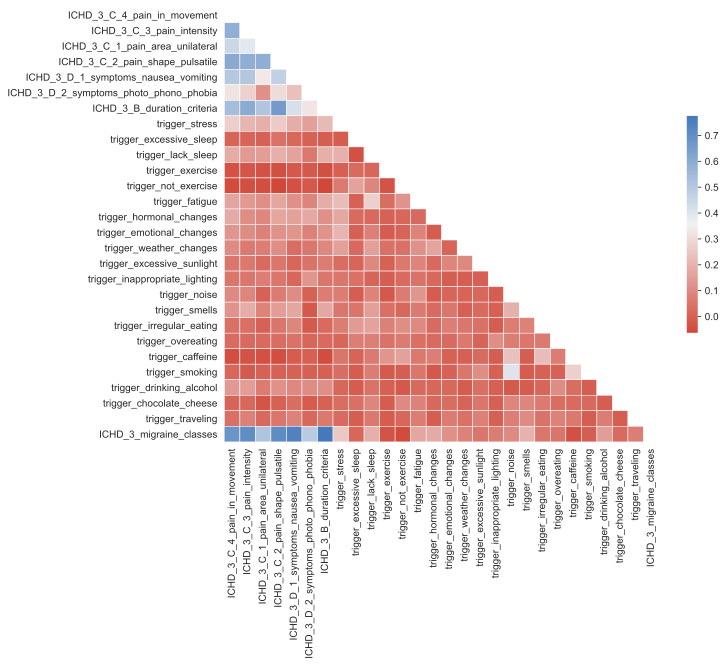

In [12]:
# use the pands .corr() function to compute pairwise correlations for the dataframe
corr = dframe.drop(columns=['ICHD_3_migraine', 'ICHD_3_probable_migraine', 'ICHD_3_no_migraine']).corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(15, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


## 1.3 Clasificar las variables dependientes (*classes*) y la independientes (*features*) .  
Creando el *dataframe* con las características de entrada ***X*** y el de las clases buscadas ***Y (ICHD_3_migraine, ICHD_3_probable_migraine, ICHD_3_no_migraine)*** las cuales han sido agrupadas en la columna ***ICHD_3_migraine_classes*** que puede tener 3 valores:
* 2 para ***ICHD_3_migraine*** 
* 1 para ***ICHD_3_probable_migraine***  
* 0 para ***ICHD_3_no_migraine***  

In [13]:
# Splitting dataset into classes and features
# y['ICHD_3_migraine_classes'] -> (2, ICHD_3_migraine) (1, ICHD_3_probable_migraine) and (0, ICHD_3_no_migraine)
y = dframe.filter(['ICHD_3_migraine_classes']) 
# features are all columns except classes
X = dframe.iloc[ : ,  :(len(dframe.columns) - 4)]
# Remove ICHD features
XOnlyTriggers = dframe.drop(columns=['ICHD_3_B_duration_criteria', 'ICHD_3_C_1_pain_area_unilateral', 
                                     'ICHD_3_C_2_pain_shape_pulsatile', 'ICHD_3_C_3_pain_intensity',
                                     'ICHD_3_C_4_pain_in_movement','ICHD_3_D_1_symptoms_nausea_vomiting',
                                     'ICHD_3_D_2_symptoms_photo_phono_phobia','ICHD_3_migraine', 
                                     'ICHD_3_probable_migraine', 'ICHD_3_no_migraine','ICHD_3_migraine_classes'])
XOnlyICHD = dframe[['ICHD_3_B_duration_criteria', 'ICHD_3_C_1_pain_area_unilateral', 
                                     'ICHD_3_C_2_pain_shape_pulsatile', 'ICHD_3_C_3_pain_intensity',
                                     'ICHD_3_C_4_pain_in_movement','ICHD_3_D_1_symptoms_nausea_vomiting',
                                     'ICHD_3_D_2_symptoms_photo_phono_phobia']]
XMainTriggers = dframe[['ICHD_3_B_duration_criteria', 'ICHD_3_C_1_pain_area_unilateral', 
                                     'ICHD_3_C_2_pain_shape_pulsatile', 'ICHD_3_C_3_pain_intensity',
                                     'ICHD_3_C_4_pain_in_movement','ICHD_3_D_1_symptoms_nausea_vomiting',
                                     'ICHD_3_D_2_symptoms_photo_phono_phobia','trigger_stress',
                                     'trigger_hormonal_changes', 'trigger_lack_sleep','trigger_fatigue',
                                     'trigger_drinking_alcohol' , 'trigger_weather_changes']]

# Display multiclass y, when 0 = no_migraine, 1 = problable_migraine and 2 = migraine
display(y)
display(X)
#display(XOnlyTriggers)
#display(XOnlyICHD)

ICHD_3_migraine_classes
0                           1
1                           1
2                           0
3                           1
4                           0
...                       ...
4573                        2
4574                        0
4575                        0
4576                        2
4577                        0

[4578 rows x 1 columns]

ICHD_3_C_4_pain_in_movement  ICHD_3_C_3_pain_intensity  \
0                               1                          1   
1                               0                          1   
2                               0                          1   
3                               1                          1   
4                               0                          1   
...                           ...                        ...   
4573                            1                          1   
4574                            0                          0   
4575                            0                          0   
4576                            1                          1   
4577                            0                          0   

      ICHD_3_C_1_pain_area_unilateral  ICHD_3_C_2_pain_shape_pulsatile  \
0                                   0                                1   
1                                   0                                1   
2                                   1                                1   
3                                   1                                1   
4                                   1                                1   
...                               ...                              ...   
4573                                0                                0   
4574                                0                                1   
4575                                0                                0   
4576                                0                                1   
4577                                0                                0   

      ICHD_3_D_1_symptoms_nausea_vomiting  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
4573                                    1   
4574                                    0   
4575                                    0   
4576                                    1   
4577                                    0   

      ICHD_3_D_2_symptoms_photo_phono_phobia  ICHD_3_B_duration_criteria  \
0                                          0                           1   
1                                          0                           1   
2                                          0                           0   
3                                          0                           1   
4                                          0                           0   
...                                      ...                         ...   
4573                                       0                           1   
4574                                       0                           1   
4575                                       0                           0   
4576                                       0                           1   
4577                                       0                           0   

      trigger_stress  trigger_excessive_sleep  trigger_lack_sleep  ...  \
0                  0                        0                   0  ...   
1                  0                        0                   0  ...   
2                  0                        0                   0  ...   
3                  0                        0                   0  ...   
4                  0                        0                   0  ...   
...              ...                      ...                 ...  ...   
4573               0                        0                   1  ...   
4574               0                        0                   0  ...   
4575               1                        0                   1  ...   
4576               0                        0                   1  ...   
4577               0                        0                   1  ...   

     

## 1.4 *Dataset* desbalanceado.  
En este caso la el objetivo buscado es predecir las clases ***Migraña*** o ***Probable migraña***, las cuales corresponden a las clases minoritarias de un dataset desbalanceado con un ratio del ***5.8%*** y del ***8.8%*** respectivamente frente al ***85.4%*** de la clase mayoritaria ***No migraña*** ... como se puede observar en la siguiente imagen:

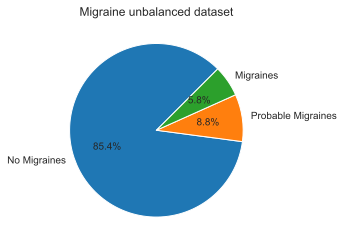

In [5]:
migraine_count = np.count_nonzero(dframe['ICHD_3_migraine'].to_numpy())
probable_migraine_count = np.count_nonzero(dframe['ICHD_3_probable_migraine'].to_numpy())
no_migraine_count = dframe['ICHD_3_migraine'].count() - migraine_count - probable_migraine_count
Migraines = [no_migraine_count, probable_migraine_count, migraine_count]
stringLabels = ['No Migraines','Probable Migraines', 'Migraines']
plt.pie(Migraines, labels=stringLabels, startangle=45, autopct='%.1f%%')
plt.title('Migraine unbalanced dataset')
plt.show()
#display(Migraines)

# 2 Utilizando el modelo *logistic regression*.  
Este modelo de aprendizaje es conveniente cuando se dispone de muchas variables independientes de entrada con valores binarios (0/1) y una o varias variables dependientes de salida.  
***TODO*** explicar porque el modelo de regressión es conveniente para este tipo de datasets y un poco de teoría. 

## 2.1 Todos los datos como datos de entrenamiento (Primer planteamiento).  
Utilizando todos los datos como datos de entrenamiento, como se muestra a continuación, se obtiene una precisión del ***92,7%***, pero es una medida engañosa por dos motivos:  
- Utilizando todos los datos como datos de entrenamiento se corre el riesgo bastante probable de tener ***overfitting***, es decir, que el modelo se ajuste perfectamente a los datos de entrenamiento pero cuando es probado datos de prueba no se ajustará correctamente.  
- En un *dataset* desequilibrado <u>como es el caso</u>, el modelo de aprendizaje tiende a predecir sobre todo la clase mayoritaria, en esta caso los eventos que no se corresponden a un día con migrañas. Para un ***unbalanced dataset***, es mucho más adecuado utilizar una medida como es el ***F1 score***. En este caso vemos que la ***F1 score*** tiene un valor mucho peor de un ***14.9%*** respecto a la ***precisión***. Por lo tanto, el modelo obtenido applicando el clasificador de regresión logistica sin dividir los datos y además si aplicar ajustes propios de un dataset desbalanceado <u>***no es adecuado***</u>.

Accuracy:  0.9967234600262124
F1 score:  [0.99936053 0.98122653 0.98141264]
Recall score:  [0.99923274 0.97270471 0.99622642]


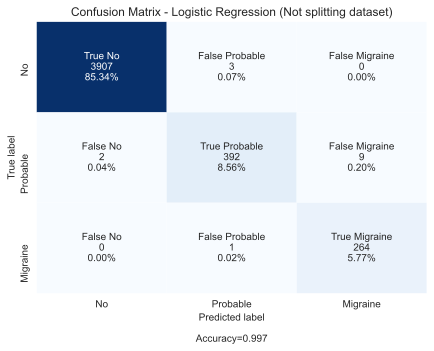

In [14]:
# Scikit-learn, integrating the logistic regression algorithm
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

# multinomial logistic regression model
LR_ModelNoDiv = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model
LR_ModelNoDiv.fit(X.values,y.values.ravel())

# Predict the output classes 'migraine', 'probable_migraine' and 'no_migraine' for samples in X
yMigrainePredictNoDiv = LR_ModelNoDiv.predict(X)

# accuracy  score
print("Accuracy: ",accuracy_score(y, yMigrainePredictNoDiv))
# balanced F-score
print("F1 score: " , f1_score(y, yMigrainePredictNoDiv, average=None))
# recall_score
print("Recall score: " , recall_score(y, yMigrainePredictNoDiv, average=None))
# confusion matrix
#print("Confusion Matrix: \r\n", confusion_matrix(y, yMigrainePredictNoDiv))
labels = ['True No','False Probable','False Migraine','False No', 'True Probable',
         'False Migraine', 'False No','False Probable','True Migraine']
categories = ['No', 'Probable','Migraine']
make_confusion_matrix(confusion_matrix(y, yMigrainePredictNoDiv), group_names=labels, categories=categories,
                      title='Confusion Matrix - Logistic Regression (Not splitting dataset)', 
                      cbar=False, figsize=(7,5))

## 2.2 Dividir los datos en datos de prueba y de entrenamiento.  
Cuando todos los datos procedentes del dataset se usan como datos de entrenamiento, como en el apartado anterior, se puede obtener una precisión en el modelo muy elevada ***99,67%*** que puede ser engañosa debido a un sobreajuste ***overfitting*** que provoque que el modelo siga a la perfeción o casi todas las muestras de entrenamiento, y sin embargo, no se ajuste bien a nuevos datos (predicciones) que es lo que se busca obtener.  
Nota: ***TODO*** explicar más en detalle el overfitting incluyendo gráficas de lo que es una regresión con sobreajuste respecto a la que no es.  

Un punto de partida para evitar el sobreajuste es dividir el dataset dos partes:
* <ins>*Datos de prueba*</ins>, es decir, datos nuevos, para ver si el modelo se ajusta correctamente, un porcentaje de un 20% suele ser una elección habitual.
* El resto como <ins>*datos de entrenamiento*</ins> del modelo, en este caso el 80%.  
Nota: ***TODO*** explicar en detalle las medidas estadísticas, sobre todo porque es interesante el F1 score para *datasets* desbalanceados como este...  
En los siguientes enlaces tenemos un buen punto de partida para hablar sobre el F1 score:  
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/  
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py  


F1 score - Not balanced:  [0.99936102 0.9689441  0.96226415]
Recall score - Not balanced:  [1.         0.96296296 0.96226415]


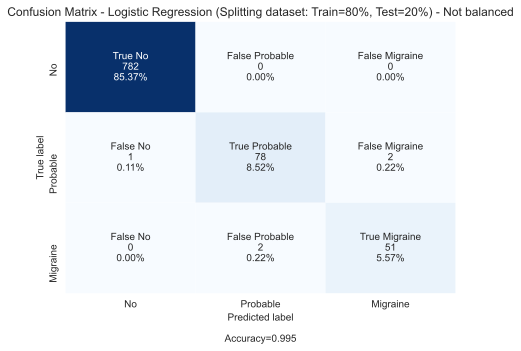

In [15]:
# Scikit-learn, split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# Scikit-learn, K-Folds cross-validator
# Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold
# Evaluate a score by cross-validation
from sklearn.model_selection import cross_val_score
# Accuracy classification score.
from sklearn.metrics import accuracy_score
# Compute confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import confusion_matrix
# Compute the F1 score, also known as balanced F-score or F-measure
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# spliting 20% (test data), 80% (training data)
# with 'random_state=1' everytime the result will be the same
XTrain, XTest, yTrain, yTest = train_test_split(X.values, y.values.ravel(), test_size = 0.2, \
                                                stratify=y, random_state=0)

# Instance the classifier object, 
# In this case, the 'random_state' passed value 
# will have an effect on the reproducibility of the results 
# returned by the function (fit, split, or any other function like k_means)
LR_ModelNoBalanced = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = 0)


# Fit the model according to the given training data
# Note: .ravel() will convert 'y' array shape to (n, ) to avoid the warning:
#       "DataConversionWarning: A column-vector y was passed when a 1d array was expected. 
#        Please change the shape of y to (n_samples, ), for example using ravel()."
yMigrainePredictNoBalanced  = LR_ModelNoBalanced.fit(XTrain,yTrain.ravel()).predict(XTest)

# Print the main metrics using logistic regression model, only split training and testing data
# accuracy  score
#print("Accuracy - Not balanced: ",accuracy_score(yTest, yMigrainePredictNoBalanced))
# balanced F-score
print("F1 score - Not balanced: " , f1_score(yTest, yMigrainePredictNoBalanced, average=None))
# recall_score
print("Recall score - Not balanced: " , recall_score(yTest, yMigrainePredictNoBalanced, average=None))


# confusion matrix
#print("Confusion Matrix: \r\n", confusion_matrix(y, yMigrainePredictNoDiv))
labels = ['True No','False Probable','False Migraine','False No', 'True Probable',
         'False Migraine', 'False No','False Probable','True Migraine']
categories = ['No', 'Probable','Migraine']
make_confusion_matrix(confusion_matrix(yTest, yMigrainePredictNoBalanced), group_names=labels, categories=categories,
                      title='Confusion Matrix - Logistic Regression (Splitting dataset: Train=80%, Test=20%) - '
                      +'Not balanced', 
                      cbar=False, figsize=(7,5))


## 2.3 Ajustar los pesos de un ***dataset*** desbalanceado para mejorar el modelo.  

Colocar en el modelo de regresión logistica el parámetro ***class_weight = 'balanced'*** es muy conveniente ya que los pesos se ajustan inversamente proporcional a la frecuencia de las clase, lo cual es fundamental cuando el *dataset* es desbanlanceado como es el caso y se quiere obtener una buena precisión para las clases de menor frecuencia.  


F1 score - Balanced:  [0.99161831 0.9132948  0.98148148]
Recall score -  Balanced:  [0.98337596 0.97530864 1.        ]


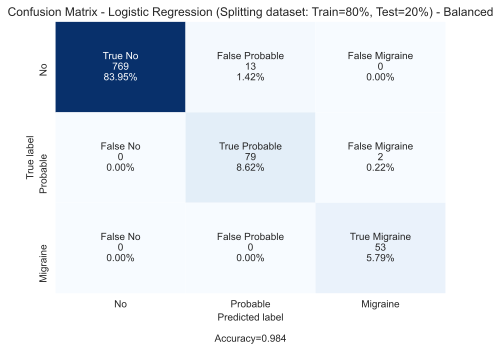

In [16]:
# Scikit-learn, split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# Scikit-learn, K-Folds cross-validator
# Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold
# Evaluate a score by cross-validation
from sklearn.model_selection import cross_val_score
# Accuracy classification score.
from sklearn.metrics import accuracy_score
# Compute confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import confusion_matrix
# Compute the F1 score, also known as balanced F-score or F-measure
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# Instance the classifier object, 
# In this case, the 'random_state' passed value 
# will have an effect on the reproducibility of the results 
# returned by the function (fit, split, or any other function like k_means)
# class_weight = 'balanced' (convenient for unbalanced dataset) ->  mode uses the values of y to automatically adjust
# weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
LR_Model = LogisticRegression(multi_class='multinomial', 
                                        solver='lbfgs', 
                                        random_state = 0, 
                                        class_weight = 'balanced')


# spliting 20% (test data), 80% (training data)
# with 'random_state=1' everytime the result will be the same
#XTrain, XTest, yTrain, yTest = train_test_split(X.values, y.values.ravel(), test_size = 0.2, \
#                                                stratify=y, random_state=0)

# Fit the model according to the given training data
# Note: .ravel() will convert 'y' array shape to (n, ) to avoid the warning:
#       "DataConversionWarning: A column-vector y was passed when a 1d array was expected. 
#        Please change the shape of y to (n_samples, ), for example using ravel()."
yMigrainePredict  = LR_Model.fit(XTrain,yTrain.ravel()).predict(XTest)

#print(LR_Model.coef_) # returns a matrix of weights (coefficients)

# Print the main metrics using logistic regression model, only split training and testing data
# accuracy  score
#print("Accuracy: ",accuracy_score(yTest, yMigrainePredict))
# balanced F-score
print("F1 score - Balanced: " , f1_score(yTest, yMigrainePredict, average=None))
# recall_score
print("Recall score -  Balanced: " , recall_score(yTest, yMigrainePredict, average=None))


# confusion matrix
#print("Confusion Matrix: \r\n", confusion_matrix(y, yMigrainePredictNoDiv))
labels = ['True No','False Probable','False Migraine','False No', 'True Probable',
         'False Migraine', 'False No','False Probable','True Migraine']
categories = ['No', 'Probable','Migraine']
make_confusion_matrix(confusion_matrix(yTest, yMigrainePredict), group_names=labels, categories=categories,
                title='Confusion Matrix - Logistic Regression (Splitting dataset: Train=80%, Test=20%) - Balanced', 
                cbar=False, figsize=(7,5))

## 2.3 Obtener las curvas *ROC* y *PRECISION-RECALL*  
TODO, explicar un poco la curva ROC  
*NOTA: Las curvas ROC han sido adaptadas del ejemplo siguiente:  
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
En *datasets* desbalanceados como es este caso, una curva interesante que permite evaluar la eficacia del modelo elegido es la curva ***PRECISION-RECALL***, la cual muestra una serie de ventajas sobre la habitual curva ***ROC*** con su área inferior ***AUC***, ya que la curva ***PRECISION-RECALL*** está más enfocada y es más hábil para informar sobre el rendimiento de modelos predictivos para *datasets* desbalanceados como indica <a id="ref_10"/>[[10] (Saito & Rehmsmeier, 2015)](#ref10)  
*NOTA: Las curvas de precisión han sido adaptadas del ejemplo siguiente: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier*

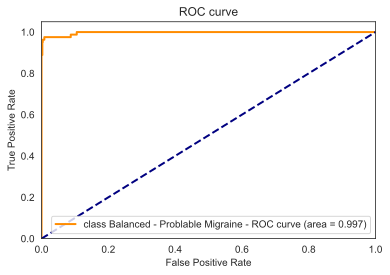

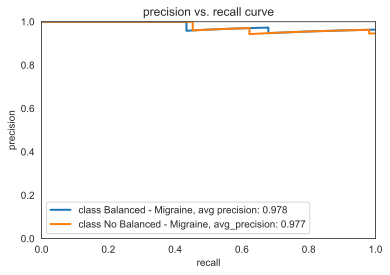

In [17]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
#%matplotlib inline

labels_plot_recall_curve_balanced = ['Balanced - No Migraine', 'Balanced - Problable Migraine',\
                                     'Balanced - Migraine']
labels_plot_recall_curve_no_balanced = ['No Balanced - No Migraine', 'No Balanced - Problable Migraine',\
                                     'No Balanced - Migraine']

def GetPredictionMigraineArray(indexPredicted, yTestArray):
    if indexPredicted == 0: #No migraine 0
        y_pred_array = np.where(yTestArray == 0, 3, yTestArray) #when 0 return 3
        y_pred_array = np.where(y_pred_array == 1, 0, y_pred_array) #when 1 return 0
        y_pred_array = np.where(y_pred_array == 2, 0, y_pred_array) #when 2 return 0
        y_pred_array = np.where(y_pred_array == 3, 1, y_pred_array) #when 3 return 1
    elif indexPredicted == 1: #Probable migraine 1
        y_pred_array  = np.where(yTestArray == 2, 0, yTestArray) #remove Migraine values '2', only '1' values
    else : #Migraine 2
        y_pred_array  = np.where(yTestArray == 1, 0, yTestArray) #remove Probable Migraine values '1', only '2' values
        y_pred_array = np.where(y_pred_array == 2, 1, y_pred_array) #pass Migraine values '2' to binary '1'
    return y_pred_array

n_classes = 3

# Predict the probabilities when the 'dataset' is 
# without 'class_weight' = 'balanced' (convenient for unbalanced dataset)  
# return matrix  'y_pred' with 3 columns -> No migraine 0, Probable Migraine 1 and Migraine 2
y_pred_no_balanced = LR_ModelNoBalanced.predict_proba(XTest)

# Predict the probabilities when the 'dataset' is splitted and 
# with 'class_weight' = 'balanced' (convenient for unbalanced dataset)  
# return matrix  'y_pred' with 3 columns -> No migraine 0, Probable Migraine 1 and Migraine 2
y_pred = LR_Model.predict_proba(XTest)

#############
# ROC curve
#############
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(GetPredictionMigraineArray(i,yTest), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='class {} - ROC curve (area = {})'.\
         format(labels_plot_recall_curve_balanced[1], round(roc_auc[1],3)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
###########################
# precision recall curve
###########################
precision_no_balanced = dict()
recall_no_balanced = dict()
precision = dict()
recall = dict()
average_precision = np.array([0.0, 0.0, 0.0], np.float64)
average_precision_no_balanced = np.array([0.0, 0.0, 0.0], np.float64)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(GetPredictionMigraineArray(i,yTest), y_pred[:, i])
    average_precision[i] = average_precision_score(GetPredictionMigraineArray(i,yTest), y_pred[:, i])
    precision_no_balanced[i], recall_no_balanced[i], _ = precision_recall_curve(GetPredictionMigraineArray(i,yTest), \
                                                                                y_pred_no_balanced[:, i])
    average_precision_no_balanced[i] = average_precision_score(GetPredictionMigraineArray(i,yTest), \
                                                               y_pred_no_balanced[:, i])
    if i==2:
        plt.plot(recall[i], precision[i], lw=2, label='class {}, avg precision: {}'.\
                 format(labels_plot_recall_curve_balanced[i],round(average_precision[i],3)))
        plt.plot(recall_no_balanced[i], precision_no_balanced[i], lw=2, label='class {}, avg_precision: {}'\
                 .format(labels_plot_recall_curve_no_balanced[i], round(average_precision_no_balanced[i],3)))
   
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.show()



## 2.4 Aplicar una validación cruzada *Stratified K-fold Cross-Validation* 
Las métricas obtendidas aplicando regresión logistica como se hace en el apartado anterior, son bastante buenas, pero es conveniente verificar los resultados haciendo una validación cruzada para comprobar que los resultados son buenos dividiendo los datos de test y de entrenamiento a lo largo de todo el *dataset* obteniendo las métricas en promedio para cada uno de los bloques de datos ***'stratified folds'***.

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# Variables for metrics average values
f1_avg_no_migraine = 0
f1_avg_possible_migraine = 0
f1_avg_migraine = 0
recall_avg_no_migraine = 0
recall_avg_possible_migraine = 0
recall_avg_migraine = 0

number_splits = 8

# Provides train/test indices to split data in train/test sets, num splits = 8
cv = KFold(n_splits=number_splits, shuffle=True, random_state = 0) 

for train_index, test_index in cv.split(X):
        XTrain, XTest = X.iloc[train_index], X.iloc[test_index]
        yTrain, yTest = y.iloc[train_index], y.iloc[test_index]
        yTrain = yTrain.values.ravel() 
        yMigrainePredictKFold = LR_Model.fit(XTrain,yTrain).predict(XTest)
        # balanced F-score
        var_f1_score =  f1_score(yTest, yMigrainePredictKFold, average=None)
        f1_avg_no_migraine = f1_avg_no_migraine + var_f1_score[0]
        f1_avg_possible_migraine = f1_avg_possible_migraine + var_f1_score[1]
        f1_avg_migraine = f1_avg_migraine + var_f1_score[2]
        #print("F1 score: " , var_f1_score)
        
        # recall_score
        var_recall_score =  recall_score(yTest, yMigrainePredictKFold, average=None)
        recall_avg_no_migraine = recall_avg_no_migraine + var_recall_score[0]
        recall_avg_possible_migraine = recall_avg_possible_migraine + var_recall_score[1]
        recall_avg_migraine = recall_avg_migraine + var_recall_score[2]
        #print("Recall score: " , var_recall_score)
# f1 metrics average   
f1_avg_no_migraine = f1_avg_no_migraine / number_splits
f1_avg_possible_migraine = f1_avg_possible_migraine / number_splits
f1_avg_migraine = f1_avg_migraine / number_splits

print("F1 average score for {0} KFold splits is: No Migraine {1}, Possible Migraine {2}, Migraine {3}"\
      .format(number_splits, round(f1_avg_no_migraine,3), round(f1_avg_possible_migraine,3), \
              round(f1_avg_migraine,3)))

# recall metrics average   
recall_avg_no_migraine = recall_avg_no_migraine / number_splits
recall_avg_possible_migraine = recall_avg_possible_migraine / number_splits
recall_avg_migraine = recall_avg_migraine / number_splits

print("Recall average score for {0} KFold splits is: No Migraine {1}, Possible Migraine {2}, Migraine {3}"\
      .format(number_splits, round(recall_avg_no_migraine,3), round(recall_avg_possible_migraine,3), \
              round(recall_avg_migraine,3)))




F1 average score for 8 KFold splits is: No Migraine 0.986, Possible Migraine 0.868, Migraine 0.982
Recall average score for 8 KFold splits is: No Migraine 0.972, Possible Migraine 0.98, Migraine 0.997


## 2.5 Ajuste del umbral óptimo del modelo  
Entre las soluciones que hay para mejorar el rendimiento del modelo obtenido en *datasets* desbalanceados como es el caso, existen varias aproximaciones o vías que se pueden intentar como quedan muy bien detalladas en los siguientes artículos <a id="ref_11"/>[[11] (Rocca, 2021)](#ref11) y <a id="ref_12"/>[[12] (Brownlee, 2020)](#ref12), entre ellas las siguientes relacionadas con modificaciones sobre los datos de partida:  
* Untilizar técnicas de submuestreo (***Undersampling***) de la clase predominante, en este caso es '***No migrañas***' frente a las otras 2 que son minoritarias '***Probable Migraine***' y '***Migraine***'. Consiste básicamente en eliminar muestras mayoritarias tratando de equilibrar la base de datos.  
* Utilizar técnicas de sobremuestreo (***Oversampling***) de la/las clases minoritarias. Consiste en generar muestras de las clases minoritarias para equilibrar la base de datos.  
* Generar nuevas muestras de las clases minoritarias de manera artificial utilizando métodos o algoritmos como el disponible en la librería <a id="ref_13"/>[[13] (Lemaître et al., 2017)](#ref13) (ver método SMOTE https://imbalanced-learn.org/stable/over_sampling.html#smote-variants por ejemplo).

Aunque en muchas ocasiones, una simple solución sin necesidad de generar o eliminar los datos originales y que suele dar buenos resultados consiste en modificar el umbral utilizado por el modelo elegido para la clasificación, que suele ser ***(typ=0.5)*** con el objetivo de encontrar el ***umbrál óptimo del modelo*** para obtener el mejor rendimiento del mismo.  
Existen varias maneras de trabajar para obtener el umbral óptimo como indica <a id="ref_12"/>[[12] (Brownlee, 2020)](#ref12) como utilizar las curvas ROC o de precisión.  
Sin embargo un método genérico siempre es adecuado sobre todo cuando el volumen de datos como es este caso no es muy elevado.

In [19]:
####################################################################################################################
# Threshold tuning functions
# Adapted from: Aprilliant, A. (2021, enero 1). Optimal Threshold for Imbalanced Classification. 
#               Medium. https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293
####################################################################################################################
def getOptimalThresholdTuning(y_pred, y_test, step_points = 1000, plotting=True, title = 'Threshold Tuning Curve', \
                              className = 'Migraine'):
    thresholds = np.arange(0.0, 1.0, 1/step_points)   # default 1000
    fscore = np.zeros(shape=(len(thresholds)))
    #print('Length of sequence: {}'.format(len(thresholds)))

    # Fit the model
    for index, elem in enumerate(thresholds):
        # Corrected probabilities
        y_pred_prob = (y_pred > elem).astype('int')
        # Calculate the f-score
        fscore[index] = f1_score(y_test, y_pred_prob)

    # Find the optimal threshold
    index = np.argmax(fscore)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    fscoreOpt = round(fscore[index], ndigits = 4)
    print('Class: {} -> Best Threshold: {} with F-Score: {}'.format(className, thresholdOpt, fscoreOpt))
    
    if plotting:
        df_threshold = pd.DataFrame({'F-score':fscore, 'Threshold':thresholds})

        # Plot the threshold tuning
        plotnine.options.figure_size = (8, 6)
        (
            print(ggplot(data = df_threshold) + \
                  geom_point(aes(x = 'Threshold', y = 'F-score'), color='blue', size = 0.35) + \
                  geom_point(aes(x = thresholdOpt, y = fscoreOpt), color = '#d4616d', size = 4) + \
                  geom_line(aes(x = 'Threshold', y = 'F-score'), color='#53b092') + \
                  geom_text(aes(x = thresholdOpt, y = fscoreOpt), \
                            label = 'Optimal threshold \n for class: {}'.format(thresholdOpt), \
                            nudge_x = 0, nudge_y = -0.10, size = 11, fontstyle = 'normal') + \
                  labs(title = title) + xlab('Threshold') + ylab('F-score') + theme_minimal())
            
            #thresholdPlot.save('./DMS_imgs/BestThresholdKFoldPlot_ProbableMigraine.pdf', height=4, width=6)  
            #print(thresholdPlot)
        )
        
    return thresholdOpt


# Variables for metrics average values

ProbableMigraineOptThresholdAveg = 0
MigraineOptThresholdAveg = 0
fold_counter = 0
plotting_threshold = False
classNames = ['No Migraine', 'Probable Migraine', 'Migraine']

for train_index, test_index in cv.split(X):
        XTrain, XTest = X.iloc[train_index], X.iloc[test_index]
        yTrain, yTest = y.iloc[train_index], y.iloc[test_index]
        yTrain = yTrain.values.ravel() 
        yMigrainePredictKFold = LR_Model.fit(XTrain,yTrain).predict(XTest)
        # Predict the probabilities for No migraine, Probable Migraine and Migrain, y_pred_array 
        y_pred_array = LR_Model.predict_proba(XTest)
        # Threshold tuning function for probable migraine
        if fold_counter == 2: 
            plotting_threshold = True  # only selected plot threshold curve
        else:
            plotting_threshold = False  
        ProbableMigraineOptThreshold = getOptimalThresholdTuning(y_pred_array[:, 1], \
                                                         GetPredictionMigraineArray(1,yTest), \
                                                         plotting=plotting_threshold, \
                                                         title = 'Threshold Tuning Curve - Probable Migraine', \
                                                         className = classNames[1])    
        MigraineOptThreshold = getOptimalThresholdTuning(y_pred_array[:, 2], \
                                                         GetPredictionMigraineArray(2,yTest), \
                                                         plotting=False, \
                                                         title = 'Threshold Tuning Curve - Migraine', \
                                                         className = classNames[2]) 

        ProbableMigraineOptThresholdAveg = ProbableMigraineOptThresholdAveg + ProbableMigraineOptThreshold
        MigraineOptThresholdAveg = MigraineOptThresholdAveg + MigraineOptThreshold
        fold_counter = fold_counter +1

ProbableMigraineOptThresholdAveg = ProbableMigraineOptThresholdAveg / fold_counter;
MigraineOptThresholdAveg = MigraineOptThresholdAveg / fold_counter;
print('Average Tuning Threshold - Probable Migraine: {}'.format(round(ProbableMigraineOptThresholdAveg,3)))
print('Average Tuning Threshold - Migraine: {}'.format(round(MigraineOptThresholdAveg,3)))


Class: Probable Migraine -> Best Threshold: 0.638 with F-Score: 0.9677
Class: Migraine -> Best Threshold: 0.75 with F-Score: 1.0
Class: Probable Migraine -> Best Threshold: 0.592 with F-Score: 0.9573
Class: Migraine -> Best Threshold: 0.368 with F-Score: 1.0
Class: Probable Migraine -> Best Threshold: 0.704 with F-Score: 0.972



Class: Migraine -> Best Threshold: 0.111 with F-Score: 0.9873
Class: Probable Migraine -> Best Threshold: 0.733 with F-Score: 0.9505
Class: Migraine -> Best Threshold: 0.576 with F-Score: 1.0
Class: Probable Migraine -> Best Threshold: 0.732 with F-Score: 0.9268
Class: Migraine -> Best Threshold: 0.423 with F-Score: 0.9846
Class: Probable Migraine -> Best Threshold: 0.661 with F-Score: 0.9541
Class: Migraine -> Best Threshold: 0.585 with F-Score: 0.9836
Class: Probable Migraine -> Best Threshold: 0.723 with F-Score: 0.9307
Class: Migraine -> Best Threshold: 0.548 with F-Score: 1.0
Class: Probable Migraine -> Best Threshold: 0.701 with F-Score: 0.9608
Class: Migraine -> Best Threshold: 0.432 with F-Score: 1.0
Average Tuning Threshold - Probable Migraine: 0.686
Average Tuning Threshold - Migraine: 0.474


Así pues el umbral promedio obtenido para la clase ***Probable Migraine***  si que tiene un cierto desplazamiento por encima del umbral por defecto ***0.5***, en este caso se ha calculado ***0.686*** .  
Sin embargo, en el análisis de todos los frames de datos, también se verifica que el umbral de la clase ***Migraine*** si que permanece entorno al valor por defecto ***0.5***, lo cual es bastante pausible teniendo en cuenta que el rendimiento de esa clase era ya bastante elevado con el umbral por defecto.  
Lo que se logra es mejorar el rendimiento de la clase minoritaria ***Probable Migraine***, como se puede observar aplicando el umbral nuevo calculado para la clase, ***0.686***.  
## 2.6 Cálculo del *f1 score*  para el umbral calculado de la clase *Probable Migraine*

In [20]:
ProbableMigraineOptThresholdAveg = 0.686
fold_counter = 0

for train_index, test_index in cv.split(X):
        XTrain, XTest = X.iloc[train_index], X.iloc[test_index]
        yTrain, yTest = y.iloc[train_index], y.iloc[test_index]
        yTrain = yTrain.values.ravel() 
        yMigrainePredictKFold = LR_Model.fit(XTrain,yTrain).predict(XTest)
        # Predict the probabilities for No migraine, Probable Migraine and Migrain, y_pred_array 
        y_pred_array = LR_Model.predict_proba(XTest)
        # Threshold tuning function for probable migraine
        # replacing predict(default threshold = 0.5) by optimal for probable migraine
        yProbableMigrainePredictThresholdOpt = (y_pred_array[:, 1] >= ProbableMigraineOptThresholdAveg).astype(int)
        # balanced F-score for optimal probable migraine threshold
        print('KFold counter {}, F1 score (Probable migraine) with optimized threshold: {}'\
          .format(fold_counter, f1_score(GetPredictionMigraineArray(1,yTest), yProbableMigrainePredictThresholdOpt)))
        fold_counter = fold_counter +1


KFold counter 0, F1 score (Probable migraine) with optimized threshold: 0.9565217391304347
KFold counter 1, F1 score (Probable migraine) with optimized threshold: 0.9565217391304348
KFold counter 2, F1 score (Probable migraine) with optimized threshold: 0.9541284403669724
KFold counter 3, F1 score (Probable migraine) with optimized threshold: 0.9320388349514563
KFold counter 4, F1 score (Probable migraine) with optimized threshold: 0.9176470588235294
KFold counter 5, F1 score (Probable migraine) with optimized threshold: 0.9541284403669724
KFold counter 6, F1 score (Probable migraine) with optimized threshold: 0.9038461538461539
KFold counter 7, F1 score (Probable migraine) with optimized threshold: 0.9514563106796116


# 3 Guardar y cargar el modelo creado  
Una vez obtenido un modelo de aprendizaje con suficiente rendimiento, como es el caso, donde se ha verificado buenos redimientos en la métrica ***f1 score*** adecuada para un *dataset* desbalanceado a lo largo de los diferentes fracciones de datos en la validación cruzada, llega el momento del empaquetado y posterior uso del modelo elegido para que pueda ser usado posteriormente, por ejemplo, desde un servidor web.  
La validación cruzada es un procedimiento para estimar el rendimiento de un método para producir un modelo y poder comparar su efectividad con otros modelos, y no para generar el modelo definitivo en sí. Por lo tanto, para que los pesos obtenidos sean sobre el mayor número de datos disponibles, se ajusta el modelo ***fit*** nuevamente pero sobre todos los datos para así empaquetar y guardar el modelo definitivo.  
Para guardarlo se usa la librería de python ***Joblib*** <a id="ref_14"/>[[14] (Joblib Development Team, 2021)](#ref14).

In [21]:
import joblib

# Recalculate the model for all dataset before save it
LR_Model.fit(X, y.values.ravel() )
# returns a matrix of weights (coefficients)
print(LR_Model.coef_) 

ProbableMigraineOptThresholdAveg = 0.686
# Predict the output classes 'migraine', 'probable_migraine' and 'no_migraine' for all dataset
yMigrainePredict = LR_Model.predict(X)
# check precision again
y_pred_array = LR_Model.predict_proba(X)
yProbableMigrainePredictThresholdOpt = (y_pred_array[:, 1] >= ProbableMigraineOptThresholdAveg).astype(int)
# balanced F-score for optimal probable migraine threshold
print('F1 score (Probable migraine) with optimized threshold: {}'\
                    .format(f1_score(GetPredictionMigraineArray(1,y), yProbableMigrainePredictThresholdOpt)))


# Save RL_Model to file in the current working directory
joblib_file = 'ADMTF_LR_Model.pkl'
# Save model as pickle file in the same directory
joblib.dump(LR_Model, joblib_file)

[[-2.16245703e+00 -2.53747605e+00 -2.06407714e+00 -2.59711351e+00
  -6.32415400e+00 -5.22753209e+00 -7.10801614e+00 -3.22520262e-01
  -2.57191629e-01 -1.08031618e-01 -6.49625864e-01  1.70697499e-01
   1.52849579e-01 -3.09261084e-01  2.49297108e-01 -4.61752019e-02
   2.61587603e-01  2.45557421e-01 -2.00342150e-01 -5.39308225e-01
   3.16199034e-01 -3.03490279e-02  4.55646177e-01  1.65294530e-01
  -4.69583344e-02  2.26820856e-03  2.33709686e-01]
 [ 1.93887799e-01 -2.10969725e-02  2.65386749e-01  4.87272765e-01
  -9.12531846e-01 -9.98729133e-01 -1.15614312e+00  6.92650443e-02
  -1.71191091e-01 -1.15458937e-01  2.93591929e-02 -3.84277290e-01
   4.79325530e-01 -5.23176408e-02 -2.11249457e-02  7.38555807e-02
  -1.42647057e-01 -4.22118132e-01 -1.26291582e-01  2.23555787e-01
   1.26585954e-01 -2.86083559e-01  6.12544847e-01  3.59206267e-01
  -4.31053701e-02 -2.75616580e-01 -5.58929366e-01]
 [ 1.96856923e+00  2.55857302e+00  1.79869039e+00  2.10984074e+00
   7.23668584e+00  6.22626123e+00  8.264

['ADMTF_LR_Model.pkl']

Ahora el paso opuesto, es decir, cargar el modelo y utilizarlo para hacer una predicción.  
En este caso se comprueba el efecto y mejora en la precisión de las predicciones desde un ***97.95 %*** a un ***99.21 %*** cuando se modifica el umbral desde ***0.5*** como valor por defecto a ***0.686*** para la clase de *Probable Migraine*. Para ello, se puede comprobar como la predicción estándar da para la muestra ***4575*** un valor de *Probable Migraine* para un umbral por defecto de *0.5*, al moverlo al calculado como óptimo podemos comprobar como mejora la precisión de las predicciones ya que esta muestra da como resultado *No Migraine* que es lo correcto.

In [22]:
# Load from file

LR_model_loaded = joblib.load(joblib_file)

# Calculate the accuracy score and predict target values
#print(X.iloc[3:4])
#print(X.iloc[4574:4575])
# Calculate the orginal Score 
score = LR_model_loaded.score(X, y)  
# Print the Score
print("Default score without specific 'Probable Migraine' class threshold: {0:.2f} %".format(100 * score))  

# Predicted array calculated without threshold
yPredicted = LR_model_loaded.predict(X) 
# Getting the probability matrix for the predicted classes
yPredictedProba = LR_model_loaded.predict_proba(X) 

yPredictedWithThreshold = np.where(yPredictedProba[:,1] >= ProbableMigraineOptThresholdAveg, 1, 0)# Probable Migraine
yPredictedWithThreshold = np.where(yPredictedProba[:,2] >= 0.5, 2, yPredictedWithThreshold)       # Migraine class

with np.printoptions(edgeitems=15): # print 15 first and last elements of array to compare it
    print('Predicted value without threshold: {}'.format(yPredicted))
    print('Predicted value with threshold:    {}'.format(yPredictedWithThreshold))
    print('Real original value:               {}'.format(y.values.ravel()))
    
# This method compare 2 arrays and return the accuracy, extracted from:
# https://stackoverflow.com/questions/38877301/how-to-calculate-accuracy-based-on-two-lists-python
#sum(1 for a,b in zip(yPredicted, y.values.ravel()) if a == b) / len(yPredicted)
print("New score with specific 'Probable Migraine' class threshold: {0:.2f} %"\
      .format(100 * sum(1 for a,b in zip(yPredictedWithThreshold, y.values.ravel()) if a == b) / \
              len(yPredictedWithThreshold)))


Default score without specific 'Probable Migraine' class threshold: 97.95 %
Predicted value without threshold: [1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 ... 0 0 0 0 0 1 2 2 0 0 2 1 0 2 0]
Predicted value with threshold:    [1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 ... 0 0 0 0 0 1 2 2 0 0 2 0 0 2 0]
Real original value:               [1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 ... 0 0 0 0 0 1 2 2 0 0 2 0 0 2 0]
New score with specific 'Probable Migraine' class threshold: 99.21 %


# <u>References</u>
* <a id="ref1"/>[[1]](#ref_1) Park, J.-W., Chu, M. K., Kim, J.-M., Park, S.-G., & Cho, S.-J. (2016). Analysis of Trigger Factors in Episodic Migraineurs Using a Smartphone Headache Diary Applications. PLoS ONE, 11(2). https://doi.org/10.1371/journal.pone.0149577
* <a id="ref2"/>[[2]](#ref_2) Vgontzas, A., & Burch, R. (2018). Episodic Migraine With and Without Aura: Key Differences and Implications for Pathophysiology, Management, and Assessing Risks. *Current Pain and Headache Reports*, *22*(12), 1-8. https://doi.org/10.1007/s11916-018-0735-z  
* <a id="ref3"/>[[3]](#ref_3) Gobel, H. (s. f.). Home. *ICHD-3 The International Classification of Headache Disorders 3rd Edition*. Recuperado 3 de febrero de 2021, de https://ichd-3.org/  
* <a id="ref4"/>[[4]](#ref_4) Marmura, M. J. (2018). Triggers, Protectors, and Predictors in Episodic Migraine. Current Pain and Headache Reports, 22(12), 81. https://doi.org/10.1007/s11916-018-0734-0  
* <a id="ref5"/>[[5]](#ref_5) Kelman, L. (2007). The triggers or precipitants of the acute migraine attack. *Cephalalgia: An International Journal of Headache*, *27*(5), 394-402. https://doi.org/10.1111/j.1468-2982.2007.01303.x  
* <a id="ref6"/>[[6]](#ref_6) Jeff Reback, Wes McKinney, jbrockmendel, Joris Van den Bossche, Tom Augspurger, Phillip Cloud, gfyoung, Simon Hawkins, Sinhrks, Matthew Roeschke, Adam Klein, Terji Petersen, Jeff Tratner, Chang She, William Ayd, Shahar Naveh, Marc Garcia, Jeremy Schendel, Andy Hayden, … Stephan Hoyer. (2021). pandas-dev/pandas: Pandas 1.2.1. Zenodo. https://doi.org/10.5281/zenodo.4452601  
* <a id="ref7"/>[[7]](#ref_7) Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, M. H., Brett, M., Haldane, A., del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362. https://doi.org/10.1038/s41586-020-2649-2  
* <a id="ref8"/>[[8]](#ref_8) Thomas A Caswell, Michael Droettboom, Antony Lee, John Hunter, Elliott Sales de Andrade, Eric Firing, Tim Hoffmann, Jody Klymak, David Stansby, Nelle Varoquaux, Jens Hedegaard Nielsen, Benjamin Root, Ryan May, Phil Elson, Jouni K. Seppänen, Darren Dale, Jae-Joon Lee, Damon McDougall, Andrew Straw, … Paul Ivanov. (2020). matplotlib/matplotlib: REL: v3.3.2. Zenodo. https://doi.org/10.5281/zenodo.4030140  
* <a id="ref9"/>[[9]](#ref_9) Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). [Scikit-learn: Machine Learning in Python](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html). Journal of Machine Learning Research, 12(85), 2825-2830. 
* <a id="ref10"/>[[10]](#ref_10) Saito, T., & Rehmsmeier, M. (2015). The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets. PLoS ONE, 10(3), e0118432. https://doi.org/10.1371/journal.pone.0118432  
* <a id="ref11"/>[[11]](#ref_11) Rocca, B. (2021, febrero 1). Handling imbalanced datasets in machine learning. Medium. https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28  
* <a id="ref12"/>[[12]](#ref_12) Brownlee, J. (2020, febrero 9). A Gentle Introduction to Threshold-Moving for Imbalanced Classification. Machine Learning Mastery. https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/  
* <a id="ref13"/>[[13]](#ref_13) Lemaître, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning. Journal of Machine Learning Research, 18(17), 1-5.
* <a id="ref14"/>[[14]](#ref_14) Joblib Development Team. (2021). Joblib: Running Python functions as pipeline jobs—Joblib 1.1.0.dev0 documentation. https://joblib.readthedocs.io/



